In [1]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install sklearn
# !pip install warnings
# !pip install category_encoders

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor 

from sklearn.linear_model import ElasticNet, Ridge, Lasso, Lars
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

import category_encoders as ce

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('dim_train.csv')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.32,Ideal,H,SI1,61.8,55.0,479,4.39,4.41,2.72
1,0.30,Ideal,E,IF,62.2,55.0,957,4.32,4.36,2.70
2,0.70,Fair,H,I1,66.5,57.0,1058,5.51,5.40,3.64
3,0.40,Very Good,E,VVS2,62.8,58.0,1066,4.68,4.71,2.95
4,1.53,Good,J,SI2,64.1,58.0,6368,7.30,7.18,4.64


### Визуализация

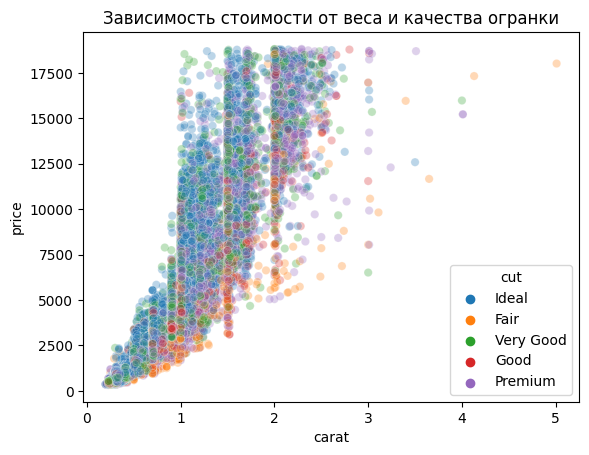

In [4]:
sns.scatterplot(df, x = 'carat', y = 'price', hue='cut', alpha = 0.3)
plt.title("Зависимость стоимости от веса и качества огранки");

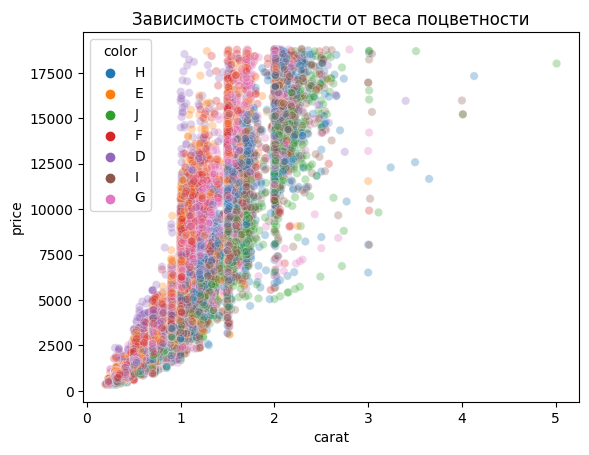

In [5]:
sns.scatterplot(df, x = 'carat', y = 'price', hue='color', alpha = 0.3)
plt.title("Зависимость стоимости от веса поцветности");

### Цена зависит от карата бриллианта не линейно, а с 'психологическими' порогами

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   price    40455 non-null  int64  
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


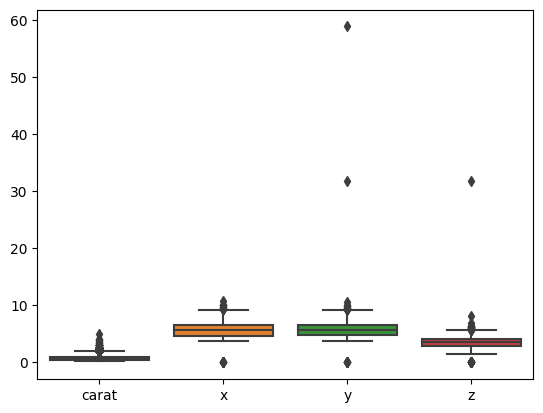

In [7]:
sns.boxplot(df.drop(columns = ['price', 'depth', 'table']));

In [8]:
df.describe()

,carat,depth,table,price,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.798351,61.752775,57.462279,3932.047831,5.732041,5.735832,3.539579
std,0.473726,1.435271,2.222987,3983.801692,1.120689,1.150850,0.709554
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.100000,56.000000,953.000000,4.720000,4.730000,2.910000
50%,0.700000,61.800000,57.000000,2415.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5310.000000,6.540000,6.540000,4.030000
max,5.010000,79.000000,73.000000,18823.000000,10.740000,58.900000,31.800000


Медиана цен смещена и находится на уровне 2415$

In [9]:
np.median(df.price)

2415.0

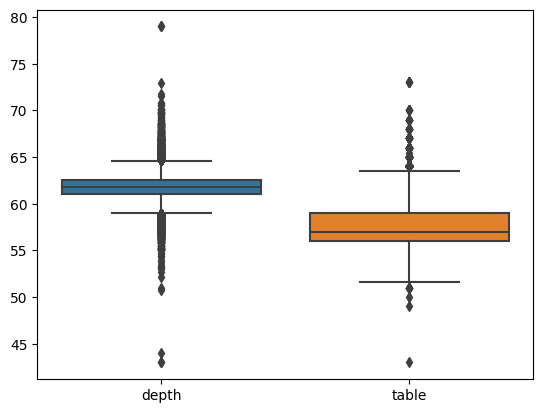

In [10]:
sns.boxplot(df[["depth", "table"]]);

Удаляем дуликаты

In [11]:
df.drop_duplicates(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40375 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40375 non-null  float64
 1   cut      40375 non-null  object 
 2   color    40375 non-null  object 
 3   clarity  40375 non-null  object 
 4   depth    40375 non-null  float64
 5   table    40375 non-null  float64
 6   price    40375 non-null  int64  
 7   x        40375 non-null  float64
 8   y        40375 non-null  float64
 9   z        40375 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.4+ MB


Выделим отдельно категориальные фичи и те, к которым мы хотим сделать полиномиальный фичинг. Также отдельно оставим фичи, где будем применять StandartScaler. Также выделим целевую переменную

In [12]:
cat_features = ['cut','color']
axis_features = ['x','y','z']
num_features = ['carat','depth','table']
y = np.array(df.price)
X = df.drop(columns=['price'])

Разделим на train/test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Выведем те бриллианты у которых хотябы одно измерение равно 0, что физически не возможно

In [14]:
X_train[(X_train.z == 0) | (X_train.y == 0) | (X_train.x == 0)]

,carat,cut,color,clarity,depth,table,x,y,z
18338,2.25,Premium,I,SI1,61.3,58.0,8.52,8.42,0.0
3606,1.50,Good,G,I1,64.0,61.0,7.15,7.04,0.0
545,1.01,Premium,H,I1,58.1,59.0,6.66,6.60,0.0
29664,1.12,Premium,G,I1,60.4,59.0,6.71,6.67,0.0
6592,1.56,Ideal,G,VS2,62.2,54.0,0.00,0.00,0.0
6487,0.71,Good,F,SI2,64.1,60.0,0.00,0.00,0.0
1528,1.00,Very Good,H,VS2,63.3,53.0,0.00,0.00,0.0
25302,2.02,Premium,H,VS2,62.7,53.0,8.02,7.95,0.0
26148,1.10,Premium,G,SI2,63.0,59.0,6.50,6.47,0.0
1818,2.80,Good,G,SI2,63.8,58.0,8.90,8.85,0.0


Для того чтобы сохранить прежние названия колонок, добавляем Imputer в axis_transformer.

In [15]:
axis_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=0, strategy='mean', add_indicator=False)),
    ('polynom', PolynomialFeatures(2,include_bias=False)),
    ('scaler', StandardScaler())])

clarity_map = [{
    'col':'clarity',
    'mapping':{'FL':10,
               'IF':9,
               'VVS1':8,
               'VVS2':7,
               'VS1':6,
               'VS2':5,
               'SI1':4,
               'SI2':3,
               'I1':2,
               'I2':1,
               'I3':0}
    }]

clarity_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', StandardScaler())
    ])
    
CT = ColumnTransformer([
        ("pol_std", axis_transformer, axis_features),
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
        ("ordinal_map", clarity_transformer, ['clarity'])
])

### Метика MAPE, наиболее полно отвечает нашей цели, а именно наиболе точно (с наименьшим отклонением определять стоимость Dimonds)
Чем меньше числитель (y_true - y_predict) тем меньше ошибка. 
Следовательно тем точнее мы определяем цену бриллианта

In [16]:
reg_list = [Ridge(), Lasso(), ElasticNet(), Lars(), KNeighborsRegressor()]

cv_list=[]

for reg in reg_list:
    pipe = Pipeline([('preprocessing', CT), 
                 ('regressor', reg)])
    pipe.fit(X_train,y_train)
    cv_res = cross_validate(pipe, X_test, y_test, cv=7, scoring = 'neg_mean_absolute_percentage_error')
    cv_list.append(cv_res['test_score'])

In [17]:
df = pd.DataFrame({
    "Ridge":cv_list[0],
    "Lasso":cv_list[1],
    "ElasticNet":cv_list[2],
    "Lars":cv_list[3],
    "KNeighbor":cv_list[4]
                  })

### Построим боксплоты для результатов по MAPE для отбора лучших моделей

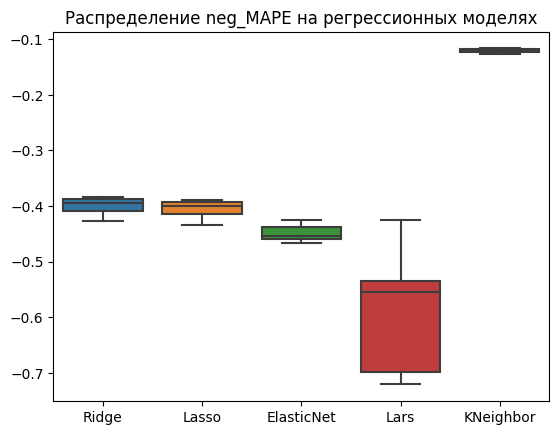

In [18]:
sns.boxplot(df);
plt.title("Распределение neg_MAPE на регрессионных моделях");

Модель Lars имеет выброс, уберём её для более качественной визуалиации, но также поже проверим с RobustScaler

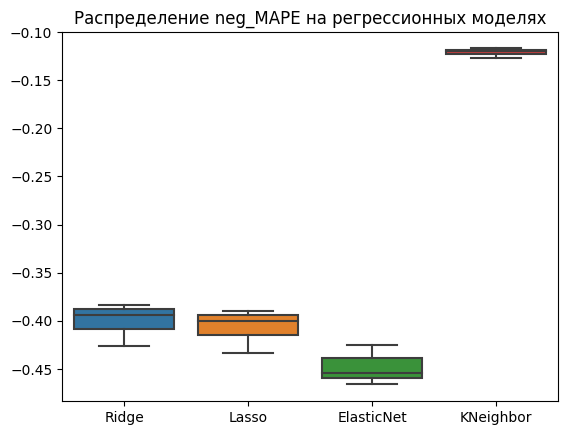

In [19]:
df = pd.DataFrame({
    "Ridge":cv_list[0],
    "Lasso":cv_list[1],
    "ElasticNet":cv_list[2],
#     "Lars":cv_list[3],
    "KNeighbor":cv_list[4]
                  })

sns.boxplot(df);
plt.title("Распределение neg_MAPE на регрессионных моделях");

## Модель регрессии на ближайших соседях однозначно лучшая, далее мы настроим суперпараметр alpha для, моделей Ridge, Lasso

Новый ColumnTramnsformer c RobustScaler

In [20]:
axis_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=0, strategy='mean', add_indicator=False)),
    ('polynom', PolynomialFeatures(2,include_bias=False)),
    ('scaler', RobustScaler())])

clarity_map = [{
    'col':'clarity',
    'mapping':{'FL':10,
               'IF':9,
               'VVS1':8,
               'VVS2':7,
               'VS1':6,
               'VS2':5,
               'SI1':4,
               'SI2':3,
               'I1':2,
               'I2':1,
               'I3':0}
    }]

clarity_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', RobustScaler())
    ])
    
CT_Robust = ColumnTransformer([
        ("pol_std", axis_transformer, axis_features),
        ("num", RobustScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
        ("ordinal_map", clarity_transformer, ['clarity'])
])

In [21]:
pipe = Pipeline([('preprocessing', CT_Robust),
                 ('regressor', Lasso())
                ])

cross_val = KFold(n_splits=3, shuffle=True)

alpha = list(np.arange(0, 20, 0.1))

param_grid =[{ 'regressor': [Ridge(), Lasso()],
     'regressor__alpha': alpha,
             }]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv = cross_val, return_train_score = True, scoring = 'neg_mean_absolute_percentage_error')

grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pol_std',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(missing_values=0)),
                                                                                         ('polynom',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['x',
                                                                          'y',
                                                                          'z']),
                                                                        ('num',
                                                                         RobustScaler(),
                                                                         ['carat',
                                                                          'depth',
                                                                          'table...
                                               0.30000000000000004, 0.4, 0.5,
                                               0.6000000000000001,
                                               0.7000000000000001, 0.8, 0.9,
                                               1.0, 1.1, 1.2000000000000002,
                                               1.3, 1.4000000000000001, 1.5,
                                               1.6, 1.7000000000000002, 1.8,
                                               1.9000000000000001, 2.0, 2.1,
                                               2.2, 2.3000000000000003,
                                               2.4000000000000004, 2.5, 2.6,
                                               2.7, 2.8000000000000003,
                                               2.9000000000000004, ...]}],
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error')

In [22]:
pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score", "std_test_score"]).T

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
mean_fit_time,0.290821,0.228859,0.227192,0.248845,0.265837,0.259842,0.246848,0.2152,0.212533,0.219198,...,0.531672,0.567983,0.602962,0.584305,0.583973,0.580308,0.574314,0.559654,0.575644,0.565251
std_fit_time,0.038108,0.001632,0.00987,0.011307,0.019189,0.042736,0.005714,0.013588,0.010264,0.017124,...,0.068906,0.069442,0.058765,0.04843,0.064357,0.063175,0.054957,0.069488,0.064603,0.065696
mean_score_time,0.066626,0.058964,0.078286,0.074291,0.061296,0.066625,0.068623,0.05863,0.068623,0.060965,...,0.075287,0.081617,0.076286,0.070292,0.068625,0.079953,0.084616,0.073623,0.075954,0.075621
std_score_time,0.015164,0.00374,0.018363,0.008572,0.001244,0.011079,0.010267,0.001246,0.009026,0.005885,...,0.002624,0.005788,0.005732,0.00464,0.014651,0.003741,0.004781,0.009024,0.008976,0.015076
param_regressor,Ridge(alpha=0.0),Ridge(alpha=0.0),Ridge(alpha=0.0),Ridge(alpha=0.0),Ridge(alpha=0.0),Ridge(alpha=0.0),Ridge(alpha=0.0),Ridge(alpha=0.0),Ridge(alpha=0.0),Ridge(alpha=0.0),...,Lasso(),Lasso(),Lasso(),Lasso(),Lasso(),Lasso(),Lasso(),Lasso(),Lasso(),Lasso()
param_regressor__alpha,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,15.7,15.8,15.9,16.0,16.1,16.2,16.3,16.4,16.5,16.6
params,"{'regressor': Ridge(alpha=0.0), 'regressor__al...","{'regressor': Ridge(alpha=0.0), 'regressor__al...","{'regressor': Ridge(alpha=0.0), 'regressor__al...","{'regressor': Ridge(alpha=0.0), 'regressor__al...","{'regressor': Ridge(alpha=0.0), 'regressor__al...","{'regressor': Ridge(alpha=0.0), 'regressor__al...","{'regressor': Ridge(alpha=0.0), 'regressor__al...","{'regressor': Ridge(alpha=0.0), 'regressor__al...","{'regressor': Ridge(alpha=0.0), 'regressor__al...","{'regressor': Ridge(alpha=0.0), 'regressor__al...",...,"{'regressor': Lasso(), 'regressor__alpha': 15....","{'regressor': Lasso(), 'regressor__alpha': 15.8}","{'regressor': Lasso(), 'regressor__alpha': 15.9}","{'regressor': Lasso(), 'regressor__alpha': 16.0}","{'regressor': Lasso(), 'regressor__alpha': 16.1}","{'regressor': Lasso(), 'regressor__alpha': 16.2}","{'regressor': Lasso(), 'regressor__alpha': 16.3}","{'regressor': Lasso(), 'regressor__alpha': 16....","{'regressor': Lasso(), 'regressor__alpha': 16.5}","{'regressor': Lasso(), 'regressor__alpha': 16.6}"
split0_test_score,-0.420687,-0.437195,-0.437406,-0.437038,-0.436655,-0.436303,-0.43598,-0.435682,-0.435405,-0.435149,...,-0.46568,-0.465918,-0.466158,-0.466399,-0.466643,-0.46689,-0.467159,-0.467408,-0.467665,-0.467944
split1_test_score,-0.399954,-0.397057,-0.397961,-0.398832,-0.399466,-0.399965,-0.400371,-0.400711,-0.401002,-0.401255,...,-0.441589,-0.441558,-0.441526,-0.441491,-0.441456,-0.441419,-0.441381,-0.441361,-0.441321,-0.441227
split2_test_score,-0.399977,-0.396086,-0.396336,-0.396808,-0.397227,-0.397566,-0.397853,-0.398104,-0.398327,-0.398531,...,-0.436102,-0.435932,-0.435761,-0.435592,-0.435423,-0.435255,-0.435088,-0.434919,-0.434752,-0.434584


##### Даже модели с подобранными параметрами не могут приблизиться к результату Алгоритма на ближайших соседях.

In [23]:
axis_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(missing_values=0, n_neighbors=4, weights="uniform")),
    ('polynom', PolynomialFeatures(2,include_bias=False)),
    ('scaler', MinMaxScaler())
    ])

clarity_map = [{
    'col':'clarity',
    'mapping':{'FL':10,
               'IF':9,
               'VVS1':8,
               'VVS2':7,
               'VS1':6,
               'VS2':5,
               'SI1':4,
               'SI2':3,
               'I1':2,
               'I2':1,
               'I3':0}
                }]

clarity_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', MinMaxScaler())
    ])
    
CT = ColumnTransformer([
        ("pol_std", axis_transformer, axis_features),
        ("num", MinMaxScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
        ("ordinal_map", clarity_transformer, ['clarity'])
        ])

In [24]:
pipe = Pipeline([('preprocessing', CT),
                 ('regressor', KNeighborsRegressor())])

cross_val = KFold(n_splits=7, shuffle=True)

n_neighbors = [4,5,6,7,8]

param_grid =[{ 'regressor': [KNeighborsRegressor()],
     'regressor__n_neighbors': n_neighbors,
     'regressor__p': [1],
     'regressor__weights': ["distance"],
     'regressor__n_jobs' : [-1]
    }]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv = cross_val, return_train_score = True, scoring = 'neg_mean_absolute_percentage_error')

grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=7, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pol_std',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(missing_values=0,
                                                                                                     n_neighbors=4)),
                                                                                         ('polynom',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['x',
                                                                          'y',
                                                                          'z']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['carat',
                                                                          'de...
                                                                                          MinMaxScaler())]),
                                                                         ['clarity'])])),
                                       ('regressor', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid=[{'regressor': [KNeighborsRegressor(n_jobs=-1,
                                                            n_neighbors=7, p=1,
                                                            weights='distance')],
                          'regressor__n_jobs': [-1],
                          'regressor__n_neighbors': [4, 5, 6, 7, 8],
                          'regressor__p': [1],
                          'regressor__weights': ['distance']}],
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error')

In [25]:
pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score", "std_test_score"]).T

,3,4,2,1,0
mean_fit_time,0.259699,0.270263,0.257557,0.238142,0.31552
std_fit_time,0.031708,0.028462,0.01521,0.023983,0.025073
mean_score_time,7.190279,7.325482,7.517221,7.315629,7.660561
std_score_time,0.149452,0.546325,0.193441,0.216096,0.279323
param_regressor,"KNeighborsRegressor(n_jobs=-1, n_neighbors=7, ...","KNeighborsRegressor(n_jobs=-1, n_neighbors=7, ...","KNeighborsRegressor(n_jobs=-1, n_neighbors=7, ...","KNeighborsRegressor(n_jobs=-1, n_neighbors=7, ...","KNeighborsRegressor(n_jobs=-1, n_neighbors=7, ..."
param_regressor__n_jobs,-1,-1,-1,-1,-1
param_regressor__n_neighbors,7,8,6,5,4
param_regressor__p,1,1,1,1,1
param_regressor__weights,distance,distance,distance,distance,distance
params,"{'regressor': KNeighborsRegressor(n_jobs=-1, n...","{'regressor': KNeighborsRegressor(n_jobs=-1, n...","{'regressor': KNeighborsRegressor(n_jobs=-1, n...","{'regressor': KNeighborsRegressor(n_jobs=-1, n...","{'regressor': KNeighborsRegressor(n_jobs=-1, n..."


##### После нескольких десятков повторений, мы нали лучшии "параметры", для предобработки и алгоритма на ближайших соседях.

----

### Final predict

In [26]:
# Путь к тренировочному набору
path_train = 'dim_train.csv' # содержит только имя файла, без имен папок
# Путь к тестовому набору
path_test  = 'dim_test.csv' # содержит только имя файла, без имен папок

X_test = pd.read_csv(path_test)

df = pd.read_csv(path_train)
X_train = df.drop(columns=['price'])
y_train = df['price']

cat_features = ['cut','color']
axis_features = ['x','y','z']
num_features = ['carat','depth','table']

In [27]:
axis_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(missing_values=0, n_neighbors=4, weights="uniform")),
    ('polynom', PolynomialFeatures(2,include_bias=False)),
    ('scaler', MinMaxScaler())
    ])

clarity_map = [{
    'col':'clarity',
    'mapping':{'FL':10,
               'IF':9,
               'VVS1':8,
               'VVS2':7,
               'VS1':6,
               'VS2':5,
               'SI1':4,
               'SI2':3,
               'I1':2,
               'I2':1,
               'I3':0}
                }]

clarity_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', MinMaxScaler())
    ])
    
CT = ColumnTransformer([
        ("pol_std", axis_transformer, axis_features),
        ("num", MinMaxScaler(), num_features),
        ("cat", OneHotEncoder(), cat_features),
        ("ordinal_map", clarity_transformer, ['clarity'])
        ])

best_pipe = Pipeline([('preprocessing', CT),
                 ('regressor', KNeighborsRegressor(n_neighbors=7, p=1, weights='distance'))])
best_pipe.fit(X_train, y_train)

y_predict = best_pipe.predict(X_test)

In [28]:
y_predict

array([  884.54940971,   787.3504698 ,   651.61434345, ...,
        8745.95400284, 17213.99215482,  1119.43203004])